In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
from keras.preprocessing import sequence
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
tokenizer = text.Tokenizer()

In [3]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k o k p",
    "h g y i u t a t e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [4]:
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}

In [5]:
corpus = [line.split(' ') for line in corpus]

In [6]:
wids = [[word2id[w] for w in sentence] for sentence in corpus]
vocab_size = len(word2id)

In [7]:
embed_size = 30
window_size = 2

In [8]:
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 31
Vocabulary Sample: [('9', 1), ('3', 2), ('o', 3), ('6', 4), ('a', 5), ('1', 6), ('g', 7), ('i', 8), ('4', 9), ('8', 10)]


In [9]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    pairs = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = context_words
            y = label_word
            pairs.append((x, y))
    return pairs

pairs = generate_context_word_pairs(wids, 2, vocab_size)

In [10]:
for pair in pairs[:5]:
  print(pair[0], pair[1])

[[16, 9]] [15]
[[15, 9, 10]] [16]
[[15, 16, 10, 4]] [9]
[[16, 9, 4, 16]] [10]
[[9, 10, 16, 2]] [4]


In [11]:
context_length = window_size*2
# xs = []
# ys = []
# for pair in pairs:
#   xs.append(sequence.pad_sequences(pair[0], maxlen=context_length))
#   ys.append(tf.one_hot(pair[1], vocab_size))

dataset = [(tf.constant(sequence.pad_sequences(pair[0], maxlen=context_length)), tf.one_hot(pair[1], vocab_size))for pair in pairs]

In [12]:
for x, y in dataset[:3]:
  print(x, y)

tf.Tensor([[ 0  0 16  9]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
tf.Tensor([[ 0 15  9 10]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
tf.Tensor([[15 16 10  4]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)


In [13]:
cbow = keras.Sequential([
  keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2),
  keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size,)),
  keras.layers.Dense(vocab_size, activation='softmax')
])

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
cbow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 30)             930       
                                                                 
 lambda (Lambda)             (None, 30)                0         
                                                                 
 dense (Dense)               (None, 31)                961       
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [14]:
for epoch in range(1, 2500):
    loss = 0.
    i = 0
    for x, y in dataset:
        i += 1
        loss += cbow.train_on_batch(x, y)
    if epoch % 20 == 0:
        print('Epoch:', epoch, '\tLoss:', loss)
        print()

2022-06-23 23:42:31.671184: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch: 20 	Loss: 487.85433328151703

Epoch: 40 	Loss: 425.58716481924057

Epoch: 60 	Loss: 384.0754727423191

Epoch: 80 	Loss: 357.73860777914524

Epoch: 100 	Loss: 338.825665384531

Epoch: 120 	Loss: 323.95460940152407

Epoch: 140 	Loss: 312.497919537127

Epoch: 160 	Loss: 302.7059075757861

Epoch: 180 	Loss: 293.58345184102654

Epoch: 200 	Loss: 285.1606238037348

Epoch: 220 	Loss: 278.33923675864935

Epoch: 240 	Loss: 272.7084418013692

Epoch: 260 	Loss: 267.32937370054424

Epoch: 280 	Loss: 262.0073923859745

Epoch: 300 	Loss: 256.7175136990845

Epoch: 320 	Loss: 251.75659237336367

Epoch: 340 	Loss: 246.2596780732274

Epoch: 360 	Loss: 241.76484165433794

Epoch: 380 	Loss: 237.89445140678436

Epoch: 400 	Loss: 234.74931484274566

Epoch: 420 	Loss: 231.86430064309388

Epoch: 440 	Loss: 228.96115501318127

Epoch: 460 	Loss: 226.13522486621514

Epoch: 480 	Loss: 223.83459512563422

Epoch: 500 	Loss: 221.85163058713078

Epoch: 520 	Loss: 220.34777769166976

Epoch: 540 	Loss: 218.92167

2022-06-23 23:46:20.844934: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 820 	Loss: 224.39985621871892

Epoch: 840 	Loss: 225.01493674630183

Epoch: 860 	Loss: 225.2890361143509

Epoch: 880 	Loss: 225.55642366850225

Epoch: 900 	Loss: 225.78642601630418

Epoch: 920 	Loss: 226.5045679444156

Epoch: 940 	Loss: 226.81495086519863

Epoch: 960 	Loss: 226.76395477216283

Epoch: 980 	Loss: 226.452402759096



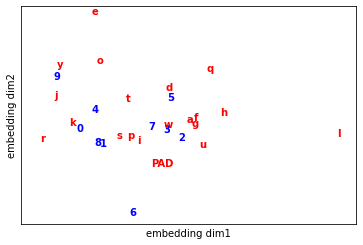

In [39]:
def show_w2v_word_embedding(model, path):
    word_emb = model.get_weights()[0]
    word_emb = word_emb[1:]
    for i in range(vocab_size -1):
        c = "blue"
        try:
            int(id2word[i])
        except ValueError:
            c = "red"
        plt.text(word_emb[i, 0], word_emb[i, 1], s=id2word[i], color=c, weight="bold")
    plt.xlim(word_emb[:, 0].min() - .5, word_emb[:, 0].max() + .5)
    plt.ylim(word_emb[:, 1].min() - .5, word_emb[:, 1].max() + .5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
    plt.savefig(path, dpi=300, format="png")
    plt.show()

show_w2v_word_embedding(cbow, './cbow.png')